In [1]:
import os
import numpy as np 
import pandas as pd
from glob import glob
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
file_path = '..\portfolio\AdienceBenchmarkGenderAndAgeClassification\\'

# Preprocessing

In [3]:
# 整合資料集
dataset = pd.DataFrame()
for i in range(5):
    fold = pd.read_csv(file_path + 'fold_' + str(i) +'_data.txt', sep = '\t')
    dataset = pd.concat([dataset, fold])
dataset = dataset.reset_index(drop=True)

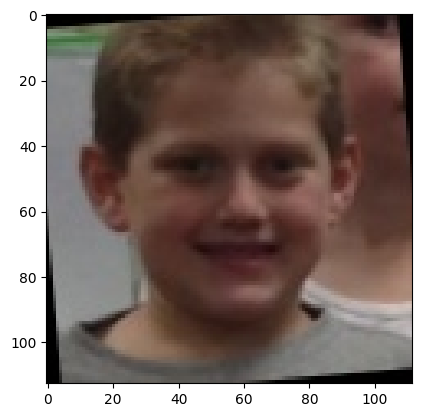

In [5]:
# Example
random.seed(0)
img_path = file_path + 'faces'
img_sample = random.randint(1, 19370)

sample_path = os.path.join(img_path,str(dataset.iloc[img_sample].user_id), 'coarse_tilt_aligned_face.' + str(dataset.iloc[img_sample].face_id) + '.' + dataset.iloc[img_sample].original_image)

image = cv2.imread(sample_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [6]:
# create path
dataset['img_path'] = dataset.apply(lambda row: f"{img_path}\\{row['user_id']}\\coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}", axis=1)

In [7]:
dataset_drop = dataset.dropna()

In [8]:
# exclude outlier
cond = dataset_drop['age'].value_counts() > 300
dataset_drop = dataset_drop[dataset_drop['age'].isin(cond[cond].index)].reset_index(drop=True)

In [9]:
X_path = dataset_drop[['img_path']]
y_gender = dataset_drop[['gender']]
y_age =  dataset_drop[['age']]
from sklearn.model_selection import train_test_split


In [10]:
# resize dataset
img_list = []
for i in range(len(dataset_drop)):
    img = cv2.imread(dataset_drop['img_path'].loc[i])
    img = cv2.resize(img, (224, 224))
    img_list.append(img)
    X = np.concatenate(img_list, axis = 0)

In [11]:
X = X.reshape(len(dataset_drop), 224,224,3)

In [12]:
y_gender.value_counts()

gender
f         8571
m         7657
u         1099
Name: count, dtype: int64

In [13]:
y_age.value_counts()

age      
(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
Name: count, dtype: int64

In [14]:
# category gender & age
gender_label_map = {
    'f': 0,
    'm': 1,
    'u': 2
}

age_label_map = {
    '(0, 2)': 0,
    '2': 0,
    '3': 0,
    '(4, 6)': 1,
    '(8, 12)': 1,
    '(8, 23)': 1,
    '13': 1,
    '(15, 20)': 2,
    '22': 2,
    '23': 2,
    '29': 2,
    '(25, 32)': 2,
    '(27, 32)': 2,
    '34': 3,
    '35': 3,
    '36': 3,
    '(38, 42)': 3,
    '(38, 43)': 3,
    '42': 3,
    '45': 4,
    '46': 4,
    '(38, 48)': 4,
    '(48, 53)': 5,
    '55': 5,
    '57': 5,
    '58': 5,
    '(60, 100)': 6   
}

In [16]:
y_gender['gender'] = y_gender['gender'].apply(lambda x: gender_label_map.get(x, x))
y_age['age'] = y_age['age'].apply(lambda x: age_label_map.get(x, x))

C:\Users\USER\AppData\Local\Temp\ipykernel_10736\691800660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_gender['gender'] = y_gender['gender'].apply(lambda x: gender_label_map.get(x, x))
C:\Users\USER\AppData\Local\Temp\ipykernel_10736\691800660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_age['age'] = y_age['age'].apply(lambda x: age_label_map.get(x, x))


In [17]:
y_age = np.array(y_age)
y_gender = np.array(y_gender)

In [18]:
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(X, y_gender,y_age, test_size=0.3, random_state=2)

# Model

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

In [20]:
input_shape=(224, 224, 3)
inputs = Input(shape=input_shape)
# VGG16
vgg16 = VGG16(weights='imagenet', include_top=False)
    
vgg_model = vgg16(inputs)
flat = Flatten()(vgg_model)

output_1 = Dense(3, activation='softmax', name='gender_out') (flat)
output_2 = Dense(7, activation='softmax', name='age_out') (flat)

model = Model(inputs=[inputs], outputs=[output_1, output_2])


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
__________________________________________________________________________________________________
gender_out (Dense)              (None, 3)            75267       flatten[0][0]                    
______________________________________________________________________________________________

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [23]:
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
clear_session()

In [24]:
train = model.fit(X_train, [y_gender_train,y_age_train], validation_split = 0.2,epochs = 50)

Epoch 1/50
304/304 [==============================] - 51s 138ms/step - loss: 17.5922 - gender_out_loss: 5.6845 - age_out_loss: 11.9076 - gender_out_accuracy: 0.7718 - age_out_accuracy: 0.5616 - val_loss: 16.4189 - val_gender_out_loss: 4.7204 - val_age_out_loss: 11.6984 - val_gender_out_accuracy: 0.8170 - val_age_out_accuracy: 0.6018
Epoch 2/50
304/304 [==============================] - 38s 125ms/step - loss: 6.3149 - gender_out_loss: 2.3902 - age_out_loss: 3.9248 - gender_out_accuracy: 0.8961 - age_out_accuracy: 0.8084 - val_loss: 17.4335 - val_gender_out_loss: 5.3108 - val_age_out_loss: 12.1227 - val_gender_out_accuracy: 0.8347 - val_age_out_accuracy: 0.6558
Epoch 3/50
304/304 [==============================] - 38s 126ms/step - loss: 3.6038 - gender_out_loss: 1.3774 - age_out_loss: 2.2264 - gender_out_accuracy: 0.9327 - age_out_accuracy: 0.8793 - val_loss: 18.6992 - val_gender_out_loss: 5.6979 - val_age_out_loss: 13.0013 - val_gender_out_accuracy: 0.8376 - val_age_out_accuracy: 0.6488

304/304 [==============================] - 38s 126ms/step - loss: 0.5002 - gender_out_loss: 0.1580 - age_out_loss: 0.3421 - gender_out_accuracy: 0.9956 - age_out_accuracy: 0.9904 - val_loss: 82.6870 - val_gender_out_loss: 26.3965 - val_age_out_loss: 56.2904 - val_gender_out_accuracy: 0.8483 - val_age_out_accuracy: 0.6686
Epoch 50/50
304/304 [==============================] - 38s 126ms/step - loss: 0.4690 - gender_out_loss: 0.1046 - age_out_loss: 0.3645 - gender_out_accuracy: 0.9955 - age_out_accuracy: 0.9892 - val_loss: 80.8521 - val_gender_out_loss: 25.7170 - val_age_out_loss: 55.1351 - val_gender_out_accuracy: 0.8495 - val_age_out_accuracy: 0.6954


In [25]:
input_shape=(224, 224, 3)
inputs = Input((input_shape))
# Resnet50
resnet = ResNet101V2(weights=None, include_top=False)

res_model = resnet(inputs)
flat = Flatten()(res_model)

output_1 = Dense(3, activation='softmax', name='gender_out') (flat)
output_2 = Dense(7, activation='softmax', name='age_out') (flat)

modelR = Model(inputs=[inputs], outputs=[output_1, output_2])



In [26]:
modelR.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet101v2 (Functional)        (None, None, None, 2 42626560    input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100352)       0           resnet101v2[0][0]                
__________________________________________________________________________________________________
gender_out (Dense)              (None, 3)            301059      flatten[0][0]                    
______________________________________________________________________________________________

In [27]:
modelR.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [28]:
train = modelR.fit(X_train, [y_gender_train,y_age_train], validation_split = 0.2,epochs = 50)

Epoch 1/70
304/304 [==============================] - 58s 174ms/step - loss: 151.3104 - gender_out_loss: 52.1549 - age_out_loss: 99.1554 - gender_out_accuracy: 0.5568 - age_out_accuracy: 0.3535 - val_loss: 114.8496 - val_gender_out_loss: 16.0207 - val_age_out_loss: 98.8289 - val_gender_out_accuracy: 0.6702 - val_age_out_accuracy: 0.2935
Epoch 2/70
304/304 [==============================] - 50s 164ms/step - loss: 89.2916 - gender_out_loss: 27.2666 - age_out_loss: 62.0249 - gender_out_accuracy: 0.6411 - age_out_accuracy: 0.4389 - val_loss: 115.5096 - val_gender_out_loss: 28.4110 - val_age_out_loss: 87.0986 - val_gender_out_accuracy: 0.5684 - val_age_out_accuracy: 0.3170
Epoch 3/70
304/304 [==============================] - 50s 164ms/step - loss: 73.4649 - gender_out_loss: 24.8162 - age_out_loss: 48.6487 - gender_out_accuracy: 0.6743 - age_out_accuracy: 0.4903 - val_loss: 47.8067 - val_gender_out_loss: 16.4573 - val_age_out_loss: 31.3494 - val_gender_out_accuracy: 0.6810 - val_age_out_acc

304/304 [==============================] - 50s 164ms/step - loss: 13.0663 - gender_out_loss: 6.8325 - age_out_loss: 6.2339 - gender_out_accuracy: 0.9221 - age_out_accuracy: 0.9217 - val_loss: 94.7462 - val_gender_out_loss: 26.7251 - val_age_out_loss: 68.0211 - val_gender_out_accuracy: 0.7968 - val_age_out_accuracy: 0.6101
Epoch 50/70
304/304 [==============================] - 50s 164ms/step - loss: 33.4502 - gender_out_loss: 11.1278 - age_out_loss: 22.3225 - gender_out_accuracy: 0.9110 - age_out_accuracy: 0.8401 - val_loss: 175.2764 - val_gender_out_loss: 35.2781 - val_age_out_loss: 139.9983 - val_gender_out_accuracy: 0.7852 - val_age_out_accuracy: 0.4402
Epoch 51/70
304/304 [==============================] - 50s 164ms/step - loss: 19.3656 - gender_out_loss: 8.4045 - age_out_loss: 10.9612 - gender_out_accuracy: 0.9115 - age_out_accuracy: 0.8990 - val_loss: 136.1820 - val_gender_out_loss: 28.1287 - val_age_out_loss: 108.0533 - val_gender_out_accuracy: 0.7716 - val_age_out_accuracy: 0.43

# Prediction

In [38]:
y_prob = model.predict(X_test)
y_prob_res = modelR.predict(X_test)

In [39]:
y_gender_pred = np.argmax(y_prob[0], axis = 1)
y_age_pred = np.argmax(y_prob[1], axis = 1)
y_gender_pred_res = np.argmax(y_prob_res[0], axis = 1)
y_age_pred_res = np.argmax(y_prob_res[1], axis = 1)

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [41]:
class_report_gender = classification_report(y_gender_test, y_gender_pred)
class_report_age = classification_report(y_age_test, y_age_pred)
class_report_gender_res = classification_report(y_gender_test, y_gender_pred_res)
class_report_age_res = classification_report(y_age_test, y_age_pred_res)

In [42]:
print(class_report_gender)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2528
           1       0.87      0.83      0.85      2330
           2       0.71      0.79      0.75       341

    accuracy                           0.86      5199
   macro avg       0.82      0.84      0.82      5199
weighted avg       0.86      0.86      0.86      5199



In [43]:
print(class_report_age)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       766
           1       0.70      0.73      0.72      1231
           2       0.71      0.77      0.74      1980
           3       0.48      0.43      0.45       696
           5       0.42      0.29      0.34       258
           6       0.75      0.48      0.58       268

    accuracy                           0.69      5199
   macro avg       0.65      0.60      0.62      5199
weighted avg       0.69      0.69      0.69      5199



In [44]:
print(class_report_gender_res)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2528
           1       0.82      0.72      0.77      2330
           2       0.63      0.59      0.61       341

    accuracy                           0.78      5199
   macro avg       0.74      0.72      0.73      5199
weighted avg       0.78      0.78      0.78      5199



In [45]:
print(class_report_age_res)

              precision    recall  f1-score   support

           0       0.72      0.77      0.75       766
           1       0.47      0.81      0.59      1231
           2       0.74      0.50      0.60      1980
           3       0.45      0.38      0.42       696
           5       0.24      0.28      0.26       258
           6       0.95      0.13      0.23       268

    accuracy                           0.57      5199
   macro avg       0.60      0.48      0.47      5199
weighted avg       0.62      0.57      0.56      5199

